visualize box plots for sentiment score distribution

----

In [1]:
import scipy as sp

In [ ]:
import pandas as pd

In [4]:
#df = pd.read_csv('data/sentiment.csv')
df = pd.read_stata('data/sentiment-topic_diversity.dta')
df.head(2)

,level_0,index,type,disease,compound,neg,neu,pos,age,gender,role,role_binary,topic_diversity
0,0,0,q,psychiatric topics,-0.6515,0.123,0.776,0.101,32.0,0,patient,1,1.561658
1,1,2207,q,neurology topics,-0.9760,0.145,0.793,0.062,32.0,0,patient,1,0.086766


In [26]:
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

---

#### gender

female vs. male

In [7]:
sp.stats.ttest_ind(df[df.gender==1]['compound'].values,
                   df[df.gender==0]['compound'].values)

(-2.23536969038807, 0.025403080837245143)

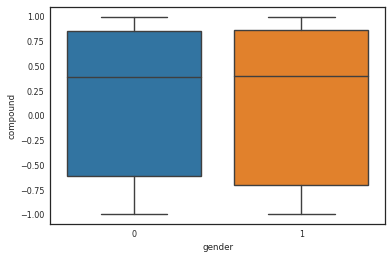

In [8]:
sns.boxplot(x='gender', y='compound', data=df)

---

#### occupation

patient vs. doctor

In [9]:
sp.stats.ttest_ind(df[df.role_binary==1]['compound'].values,
                   df[df.role_binary==0]['compound'].values)

(-64.55135844461559, 0.0)

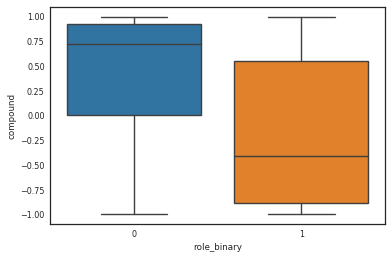

In [10]:
sns.boxplot(x='role_binary', y='compound', data=df)

---

#### female

In [11]:
sp.stats.ttest_ind(df[(df.role_binary==1)&(df.gender==1)]['compound'].values,
                   df[(df.role_binary==0)&(df.gender==1)]['compound'].values)

(-64.69486412499096, 0.0)

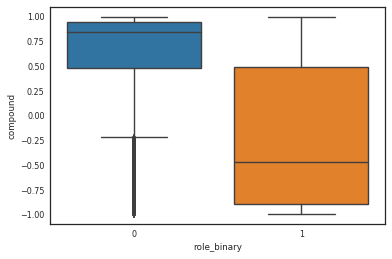

In [12]:
sns.boxplot(x='role_binary', y='compound', data=df.query('gender==1'))

---

#### male

In [13]:
sp.stats.ttest_ind(df[(df.role_binary==1)&(df.gender==0)]['compound'].values,
                   df[(df.role_binary==0)&(df.gender==0)]['compound'].values)

(-30.492625734422642, 2.8285434759403912e-196)

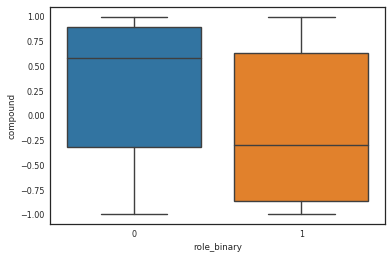

In [14]:
sns.boxplot(x='role_binary', y='compound', data=df.query('gender==0'))

---

#### patient

In [15]:
sp.stats.ttest_ind(df[(df.gender==1)&(df.role_binary==1)]['compound'].values,
                   df[(df.gender==0)&(df.role_binary==1)]['compound'].values)

(-6.181983149508034, 6.58763716466045e-10)

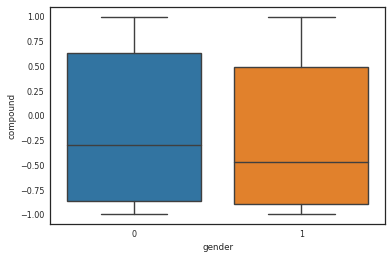

In [16]:
sns.boxplot(x='gender', y='compound', data=df.query('role_binary==1'))

---

#### doctor

In [17]:
sp.stats.ttest_ind(df[(df.gender==1)&(df.role_binary==0)]['compound'].values,
                   df[(df.gender==0)&(df.role_binary==0)]['compound'].values)

(24.346240802625214, 6.258568130568341e-128)

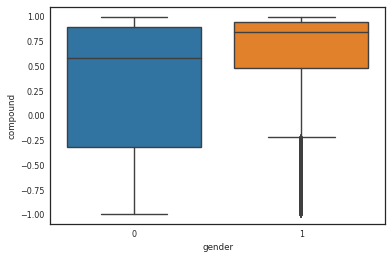

In [18]:
sns.boxplot(x='gender', y='compound', data=df.query('role_binary==0'))

---

#### regression

4 models:
- role
- gender
- role + gender
- role + gender + role x gender

In [20]:
import statsmodels.formula.api as smf

In [21]:
df.head(2)

,level_0,index,type,disease,compound,neg,neu,pos,age,gender,role,role_binary,topic_diversity
0,0,0,q,psychiatric topics,-0.6515,0.123,0.776,0.101,32.0,0,patient,1,1.561658
1,1,2207,q,neurology topics,-0.9760,0.145,0.793,0.062,32.0,0,patient,1,0.086766


In [38]:
df['compound_std'] = (df['compound'].values - df['compound'].mean()) / df['compound'].std()

In [39]:
r_reg = smf.ols('compound_std ~ role_binary', data=df).fit()
g_reg = smf.ols('compound_std ~ gender', data=df).fit()
rg_reg = smf.ols('compound_std ~ role_binary + gender', data=df).fit()
rg_inter_reg = smf.ols('compound_std ~ role_binary*gender', data=df).fit()

In [43]:
coef_df = pd.DataFrame()
#for i, mod in enumerate([r_reg, g_reg, rg_reg, rg_inter_reg]):
for i, mod in enumerate([rg_reg, rg_inter_reg]):
    err_series = mod.params - mod.conf_int()[0]
    coef_df = coef_df.append(pd.DataFrame({'coef': mod.params.values[1:],
                                           'err': err_series.values[1:],
                                           'varname': err_series.index.values[1:],
                                           'model': 'model %d'%(i+1)
                                          })
                            )
coef_df

,coef,err,model,varname
0,-0.842536,0.025016,model 1,role_binary
1,0.163064,0.024820,model 1,gender
0,-0.577705,0.035752,model 2,role_binary
1,0.384771,0.032712,model 2,gender
2,-0.510016,0.049615,model 2,role_binary:gender


In [97]:
## marker to use
#marker_list = 'soxv'
marker_list = 'vo'
width=0.25
## 3 covariates in total
base_x = pd.np.arange(3) - 0.2
base_x

array([-0.2,  0.8,  1.8])

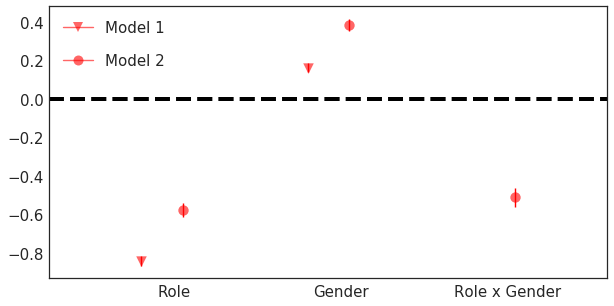

In [99]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, mod in enumerate(coef_df.model.unique()):
    mod_df = coef_df[coef_df.model == mod]
    mod_df = mod_df.set_index('varname').reindex(coef_df['varname'].unique())
    ## offset x posistions
    X = base_x + width*i
    ax.bar(X, mod_df['coef'], ecolor='r',
           color='none',yerr=mod_df['err'])
    ## remove axis labels
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x=X, 
               marker=marker_list[i], s=100, 
               y=mod_df['coef'], color='r', alpha=0.6)
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    #_ = ax.set_xticklabels(['', 'Role', 'Gender', 'Role x Gender'], 
    #                       rotation=0, fontsize=16)
    
## finally, build customized legend
legend_elements = [Line2D([0], [0], marker=m,
                          label='Model %d'%(i+1),
                          color = 'r', alpha=0.6,
                          markersize=10)
                   for i, m in enumerate(marker_list)
                  ]
_ = ax.legend(handles=legend_elements, loc=2, 
              #bbox_to_anchor=()
              prop={'size': 15}, labelspacing=1.2)

_ = ax.set_xticklabels(['']*2 +  ['Role'] + ['', 'Gender', '', 'Role x Gender'] + ['']*2, 
                       rotation=0, fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)

##### regresion fix role

In [80]:
rg_inter_reg.params

Intercept             0.202194
role_binary          -0.577705
gender                0.384771
role_binary:gender   -0.510016
dtype: float64

if role == 1:
> $sentiment = 0.202194 - 0.577705 + 0.384771*gender - 0.510016$

In [85]:
patient_points = [[0, 1], 
                  [0.202194 - 0.577705 + 0.384771*0 - 0.510016, 0.202194 - 0.577705 + 0.384771*1 - 0.510016]]
patient_points

[[0, 1], [-0.8855270000000001, -0.5007560000000001]]

if role == 0:
> $sentiment = 0.202194  + 0.384771*gender$

In [86]:
doctor_points = [[0, 1], [0.202194, 0.202194+0.384771]]
doctor_points

[[0, 1], [0.202194, 0.586965]]

Text(0,0.5,'Sentiment')

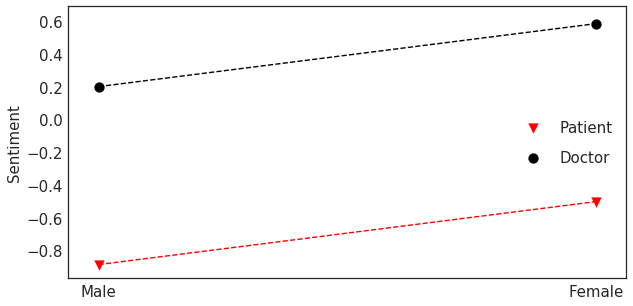

In [111]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(*patient_points, color='r', ls='--')
ax.scatter(*patient_points, color='r', marker='v', s=100, label='Patient')
ax.plot(*doctor_points, color='k', ls='--')
ax.scatter(*doctor_points, color='k', marker='o', s=100, label='Doctor')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Male', 'Female'])
ax.legend(prop={'size': 15}, 
          loc=5,
          labelspacing=1)
ax.set_ylabel('Sentiment', size=15)